# Malicious traffic classifier using Decision Trees

The script implements a network traffic antivirus that classifies packets into three classes: benign, cryptominer and bruteforce, as well as a custom implementation of a Decision Tree Classifier.

A very good resource: https://www.analyticsvidhya.com/blog/2023/01/step-by-step-working-of-decision-tree-algorithm/

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's start by visualising the dataset features and labels using pandas and matplotlib:

|    | origin_ip      |   origin_port | response_ip   |   response_port |   flow_duration |   fwd_pkts_tot |   bwd_pkts_tot |   fwd_header_size_tot |   bwd_header_size_tot |   flow_FIN_flag_count |   flow_SYN_flag_count |   flow_ACK_flag_count |   fwd_pkts_payload.avg |   bwd_pkts_payload.avg |   fwd_iat.avg |   bwd_iat.avg |   flow_pkts_payload.avg |
|---:|:---------------|--------------:|:--------------|----------------:|----------------:|---------------:|---------------:|----------------------:|----------------------:|----------------------:|----------------------:|----------------------:|-----------------------:|-----------------------:|--------------:|--------------:|------------------------:|
|  0 | 103.210.35.134 |         44948 | 184.0.48.169  |             443 |        0        |              1 |              0 |                    40 |                     0 |                     0 |                     1 |                     0 |                 0      |                  0   

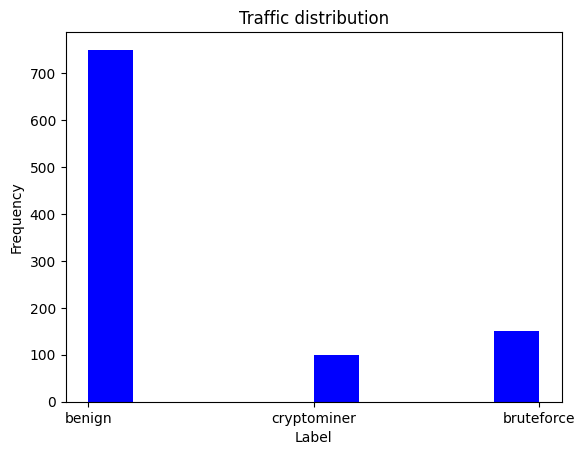

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# Hotfix to allow script to be run from anywhere
__import__('sys').path.append('..')

from preprocessing.utils import *
from preprocessing.visual_utils import *


traffic_data, labels = load_network_dataset()

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

show_dataset_md(traffic_data)
plot_labels_distribution(label_encoder.inverse_transform(labels))

We can see that most of the traffic is benign, so we must make sure that we split the dataset for training and testing without neglecting one class over the other. The main ideea behind the classifier is that each of the malicious traffic classes (cryptominer or bruteforce) has some specific properties, such as long response time or high payload length. Because these properties may be common between similar packets, a **Decision Tree** classifier may be a good solution.

Almost all the fields of the dataset are floats, only origin and response IPs are strings. So we can start parsing data by splitting each IP field into four parts using a custom transformer:

In [29]:
DF_FIELDS = traffic_data.columns
IP_FIELDS = ['origin_ip', 'response_ip']

# split the ip fields into 4 columns
ip_transformer = ColumnTransformer(
    transformers=[
        ('ip_splitter', IPTransformer(IP_FIELDS), IP_FIELDS),
    ],
    remainder='passthrough'
)

updated_traffic_data = ip_transformer.fit_transform(traffic_data)

In order to view the results, the dataset must be again converted to a pandas DataFrame, along with the new column names:

In [30]:
new_fields = ['origin_ip_ipv6'] + ['origin_ip_{0}'.format(i) for i in range(4)]
new_fields += ['response_ip_ipv6'] + ['response_ip_{0}'.format(i) for i in range(4)]
new_fields += list(DF_FIELDS.drop(IP_FIELDS))

updated_traffic_data = pd.DataFrame(updated_traffic_data, columns=new_fields)
show_dataset_md(updated_traffic_data)

|    |   origin_ip_ipv6 |   origin_ip_0 |   origin_ip_1 |   origin_ip_2 |   origin_ip_3 |   response_ip_ipv6 |   response_ip_0 |   response_ip_1 |   response_ip_2 |   response_ip_3 |   origin_port |   response_port |   flow_duration |   fwd_pkts_tot |   bwd_pkts_tot |   fwd_header_size_tot |   bwd_header_size_tot |   flow_FIN_flag_count |   flow_SYN_flag_count |   flow_ACK_flag_count |   fwd_pkts_payload.avg |   bwd_pkts_payload.avg |   fwd_iat.avg |   bwd_iat.avg |   flow_pkts_payload.avg |
|---:|-----------------:|--------------:|--------------:|--------------:|--------------:|-------------------:|----------------:|----------------:|----------------:|----------------:|--------------:|----------------:|----------------:|---------------:|---------------:|----------------------:|----------------------:|----------------------:|----------------------:|----------------------:|-----------------------:|-----------------------:|--------------:|--------------:|------------------------:|
|  0 |

We can see how the original IP fields (**origin_ip** and **response_ip**) were replaced with five new columns: one specifying if the address is ipv6 and the other four containing the IPv4 address parts (functionality not implemented for IPv6 because there are not enough samples implementing it).

Now all that is left to do is to implement the Decision Tree classifier. But before, we must split the dataset into training and test:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(updated_traffic_data, labels, test_size=0.2, stratify=labels)

# Classify using Decision Tree
rf = RandomForestClassifier(max_depth=3)
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
dt_score = dt.score(X_test, y_test)
dt_predict = dt.predict(X_test)

# View the results
dt_cmat = confusion_matrix(y_test, dt_predict)
report = classification_report(y_test, dt_predict, target_names=label_encoder.classes_)
print(report)


              precision    recall  f1-score   support

      benign       1.00      0.99      1.00       150
  bruteforce       1.00      1.00      1.00        30
 cryptominer       0.95      1.00      0.98        20

    accuracy                           0.99       200
   macro avg       0.98      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



Because each malicious packet has its weird behavior (as described above), the decision tree with depth 5 was succesfully able to filter all the bad packets, resulting in a recall and precision of 100% (meaning there is no error).

In order to see how the classifier was trained, we can display the diagram of the Decision Tree using **GraphViz**:

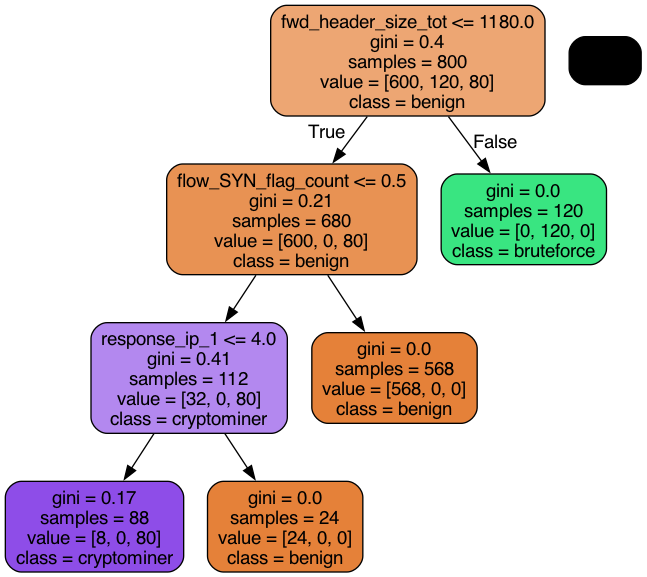

In [32]:
# estimator = rf.estimators_[5]
estimator = dt
export_graphviz(estimator, out_file='tree.dot', feature_names = updated_traffic_data.columns,
                class_names = label_encoder.classes_,
                rounded = True, proportion = False, precision = 2, filled = True)

graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

# Custom Variant

Using the custom created variant, which uses the shannon entropy as a measure of data impurity, the results are quite similar:

In [33]:
from decision_tree import DecisionTree

# Classify using Custom Decision Tree
dt = DecisionTree()
dt.fit(X_train, y_train)
dt_predict = dt.predict(X_test)

# Evaluate the model
dt_cmat = confusion_matrix(y_test, dt_predict)
report = classification_report(y_test, dt_predict, target_names=label_encoder.classes_)

print(report)

              precision    recall  f1-score   support

      benign       1.00      0.99      1.00       150
  bruteforce       1.00      1.00      1.00        30
 cryptominer       0.95      1.00      0.98        20

    accuracy                           0.99       200
   macro avg       0.98      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



As it can be seen, both models have an accuracy of almost 100%. The custom implementation can be found in decision_tree.py